## Business Scenario

The steps involved are:  

1. Get as close to the source of data as possible usually by interviewing the people involved
2. Identify the business problem
3. Obtain all of the relevant the data
4. Translate the business problem into a testable hypothesis or hypotheses

A friend of yours just opened a new Sherlock Holmes themed café. Her café is state-of-the-art complete with monitors built into the tables. The business is off to a good start, but she has gotten some feedback that the games could use improvement. She knows that good games keep the customers around a little longer. The games are a way to keep customers entertained while they drink coffee and buy food items. She has some games already, but wants your help to create a few more games to keep customers both informed and entertained.

Lets assume that your initial investigation led you to understand that games that used quotations from the books in an interactive way were the most effective. So you have come up with the idea to develop a game that is built on a chatbot that has been trained to talk like Sherlock. This would involve Natural Language Processing (NLP) and we would need a corpus. As a start you might download The Adventures of Sherlock Holmes, by Arthur Conan Doyle from Project Gutenberg.

In [13]:
import os
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [14]:
# Get corpus
if not os.path.exists('data/sherlock-holmes.txt'):
    text = requests.get('https://www.gutenberg.org/files/1661/1661-0.txt').text
    with open("data/sherlock-holmes.txt", "w", encoding="utf-8") as text_file:
        text_file.write(text)

## Data wrangling stage.

In [15]:
# Read the data
text = open('data/sherlock-holmes.txt', 'r', encoding='utf-8').read()

In [16]:
# Split sentences and basic clean up
stop_pattern = '\.|\?|\!'
sentences = re.split(stop_pattern, text)
sentences = [re.sub("\r|\n"," ",s.lower()) for s in sentences]

In [17]:
# Extract a few features and store in a dataframe
has_sherlock =  [True if re.search("sherlock|holmes",s) else False for s in sentences]
has_watson = [True if re.search("john|watson",s) else False for s in sentences]
df = pd.DataFrame({'text':sentences,'has_sherlock':has_sherlock,'has_watson':has_watson})
df['num_words'] = df['text'].apply(lambda x: len(x.split(" ")))

In [18]:
df.head()

,text,has_sherlock,has_watson,num_words
0,project gutenberg's the adventures of sherlo...,True,False,35
1,"you may copy it, give it away or re-use it ...",False,False,30
2,gutenberg,False,False,1
3,net title: the adventures of sherlock hol...,True,False,128
4,a scandal in bohemia ii,False,False,14


## Stage where we perform the initial EDA.

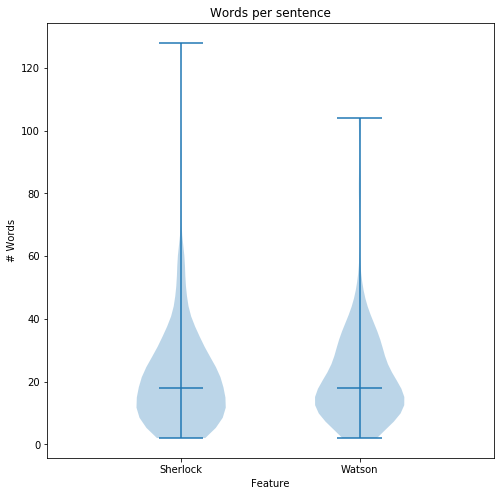

In [19]:
# Minimal example of EDA
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

data1 = df[df['has_sherlock']==True]
data2 = df[df['has_watson']==True]

data = [df[df[col]==True]['num_words'].values for col in ['has_sherlock','has_watson']]

pos = [1,2]
ax1.violinplot(data, pos, points=40, widths=0.5, showextrema=True, showmedians=True)

labels = ['Sherlock', 'Watson']
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels)
ax1.set_xlim(0.25, len(labels) + 0.75)
ax1.set_xlabel('Feature')
ax1.set_ylabel('# Words')
ax1.set_title("Words per sentence");

For our text data we would likely want to dig into the sentences themselves to make sure they fit the desired use case. If we were building a chatbot to engage with in a very Holmes manner then we would likely want to remove any sentences that were not said by Mr. Holmes, but his name was mentioned. If we were building a predictive model to determine which story a phrase would most likely have been generated, we would need to create a new column in our data frame representing the books themselves.

## Stage where we modify our data and our features.

In [20]:
# Extract the data to be used in the model from the df
labels = np.zeros(df.shape[0])
labels[(df['has_sherlock'] == True)] = 1
labels[(df['has_watson'] == True)] = 2
df['labels'] = labels
df = df[df['labels']!=0]
X = df['text'].values
y = df['labels'].values

The data have been cleaned, processed and staged (ideally in a pipeline) for modeling. The modeling (classic statistics and machine learning) is the bread and butter of data science. This is the stage where most data scientists want to spend the majority of their time. It is where you will interface with the most intriguing aspects of this discipline.

To illustrate the process to the end shown below is a Support Vector Machine with Stochastic gradient decent as a model. The process involves the use of a train-test split and a pipeline because we want you to be exposed from the very beginning of this course with best practices. Given this example we also see that there can be considerable overlap between the ideate and prototype stages. The overlap exists because transformations of data are generally specific to models–as you will explore which model fits the situation best you will be modifying the transformations of your data.

## Modeling stage.

In [21]:
# Carry out the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=42,
                        max_iter=5, tol=None))
])

# Train a model
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

The model works and there are evaluation metrics to provide insight into how well it works. However, the process does not end here. Perhaps the model runs, but it is not yet in production or maybe you want to try different models and/or transformers. Once in production you might want to run some tests to determine if it will handle load or if it will scale well as the data grows. A working model with an impressive f-score does not mean it will be effective in practice. This stage is dedicated to all of the considerations that come after the initial modeling is carried out.

It is also the stage where you will determine how best to iterate. Design thinking like data science is an iterative process. Our model performed very well (see below), possibly because Dr. Holmes and Dr. Watson are described in very different ways in the stories, but it could be something else.

## Production, testing and feedback loop stage.

In [22]:
# Evaluate the model performance
predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test, predicted,
      target_names=['sherlock','watson']))

              precision    recall  f1-score   support

    sherlock       0.97      1.00      0.98       150
      watson       1.00      0.86      0.93        36

    accuracy                           0.97       186
   macro avg       0.98      0.93      0.95       186
weighted avg       0.97      0.97      0.97       186



**This café example is meant as an illustrative tool. There are additional sanity checks, data cleaning and modeling best practices that would need to be carried out (like Grid Searching) before something like it should be used in the an actual application.**

## Analysis.

*Using the Café Sherlock example: How do you ensure new games drive revenue?*  

There are numerous correct answers and if you came up with something similar to the following your are on the right track. Because customer frequency and duration are essentially proxies for revenue and because the relationship between these data and the game is direct we ask our questions with this in mind rather than revenue directly. Asking in terms of revenue directly is not wrong in this case, but a positive correlation is harder to interpret due to likely presence of confounding factors.  
- Which games are most associated with sales?
- Is my new game a stronger predictor of frequency and duration than other games?
- Is my new game more strongly correlated with frequency and duration than other games?
- In a predictive model does my new game have a stronger feature importance then other games?  

*These results are not directly related to revenue, but for the sake of the example lets assume you needed a decent version of this model to craft a new game. How you would interpret these results?*  

In the above results output the support is the number of occurrences of each class in y_true. It follows that we have relatively unbalanced classes and we made no special accommodation for this situation. It is a major purpose of this stage to be critical and reflect on the process, the finding all the while keeping in mind the central business question. Knowing that our classes are in-balanced we need to be careful about using accuracy as a metric. We will do a deeper dive into both in-balanced classes and evaluation metrics in this course. Give a sentence we do a better job predicting a sherlock context than a watson one. This is where we want to be critical and start asking questions like:

- My game in production will likely see many different sentences.
- Would a negative class improve my model?
- I need to compare this game to the others and relate it to revenue how do I accomplish this?
- Is developing a new game even worth the effort or is there another way to use DS to help my friend?